In [1]:
import numpy as np                     # numeric python lib

import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour

from skimage import measure             # to find shape contour
from skimage import io
import scipy.ndimage as ndi            # to determine shape centrality
from skimage.exposure import histogram

# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)

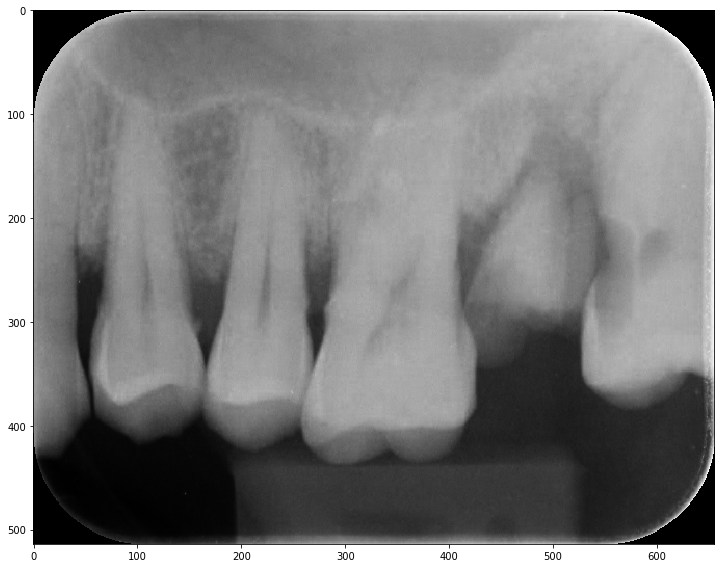

In [32]:
# reading an image file using matplotlib into a numpy array
# good ones: 11, 19, 23, 27, 48, 53, 78, 218
img = io.imread('catagorical_data/3-missing_tooth/100.jpg', as_gray = 'True' )
io.imshow(img)


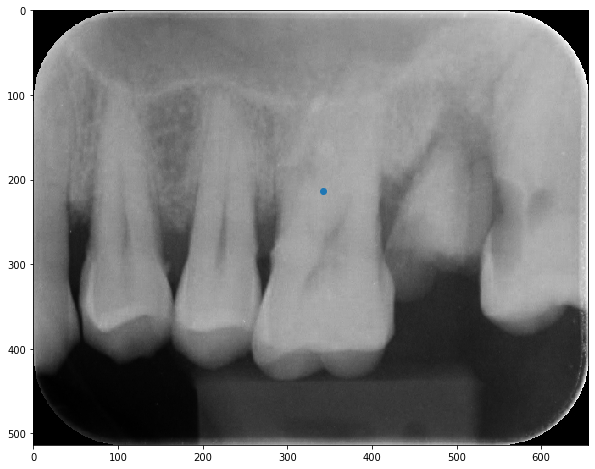

In [33]:
# using image processing module of scipy to find the center of the leaf
cy, cx  = ndi.center_of_mass(img)

plt.imshow(img, cmap='gray')  # show me the leaf
plt.scatter(cx, cy)           # show me its center
plt.show()

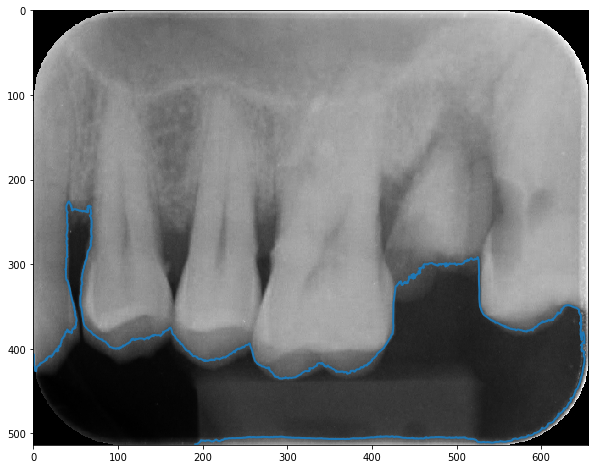

In [49]:
contours = measure.find_contours(img, .3)

# from which we choose the longest one
contour = max(contours, key=len)

# let us see the contour that we hopefully found
plt.plot(contour[::,1], contour[::,0], linewidth=2)  # (I will explain this [::,x] later)
plt.imshow(img, cmap='gray')
plt.show()

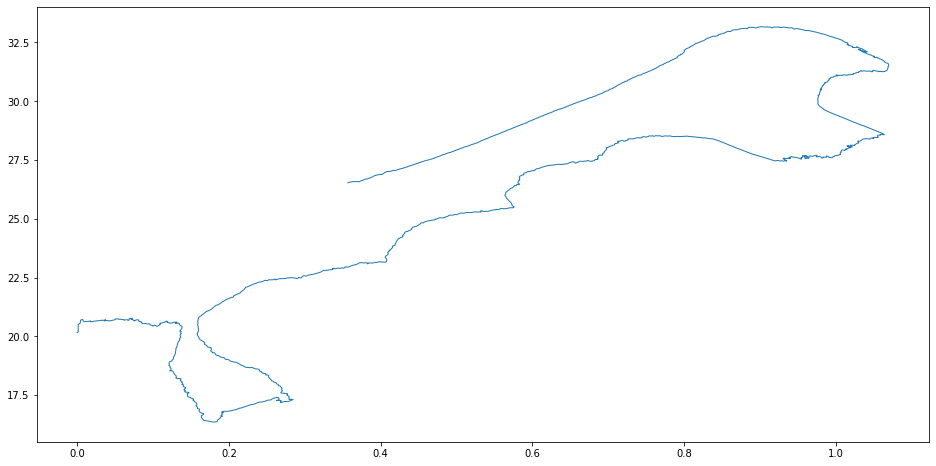

In [50]:
# cartesian to polar coordinates, just as the image shows above
def cart2pol(x, y):
    rho = np.sqrt(x + y)
    phi = np.arctan2(y, x)
    return [rho, phi]

# just calling the transformation on all pairs in the set
polar_contour = np.array([cart2pol(x, y) for x, y in contour])

# and plotting the result
plt.plot(polar_contour[::,1], polar_contour[::,0], linewidth=1)
plt.show()

In [51]:
contour[::,1] -= cx  # demean X
contour[::,0] -= cy  # demean Y

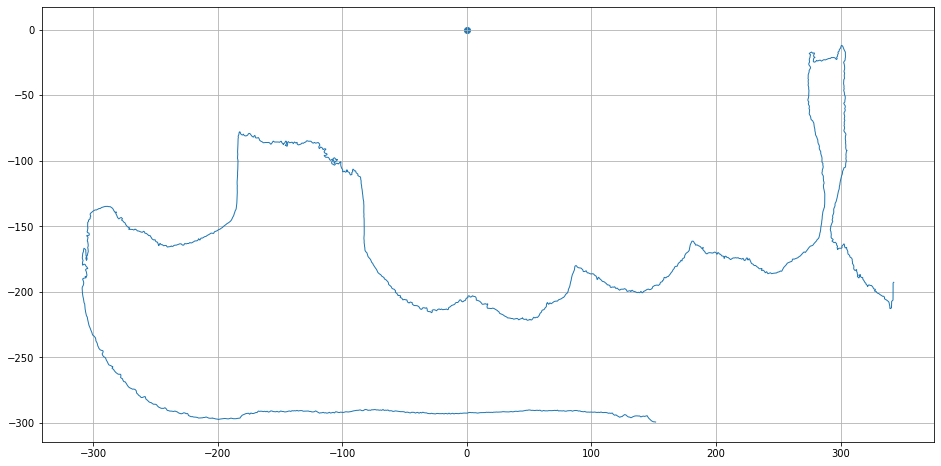

In [58]:
plt.plot(-contour[::,1], -contour[::,0], linewidth=1)
plt.grid()
plt.scatter(0, 0)
plt.show()

/home/biggooo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


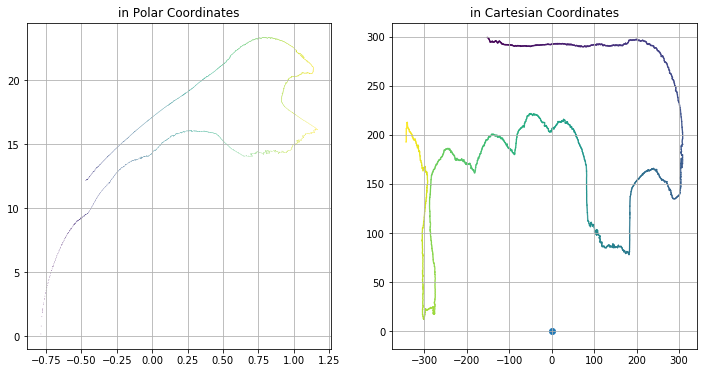

In [63]:
# just calling the transformation on all pairs in the set
polar_contour = np.array([cart2pol(x, y) for x, y in contour])

# and plotting the result
rcParams['figure.figsize'] = (12, 6)
plt.subplot(121)
plt.scatter(polar_contour[::,1], polar_contour[::,0], linewidth=0, s=.3, c=polar_contour[::,1])
plt.title('in Polar Coordinates')
plt.grid()
plt.subplot(122)
plt.scatter(contour[::,1],             # x axis is radians
            contour[::,0],             # y axis is distance from center
            linewidth=0, s=2,          # small points, w/o borders
            c=range(len(contour)))     # continuous coloring (so that plots match)
plt.scatter(0, 0)
plt.title('in Cartesian Coordinates')
plt.grid()
plt.show()

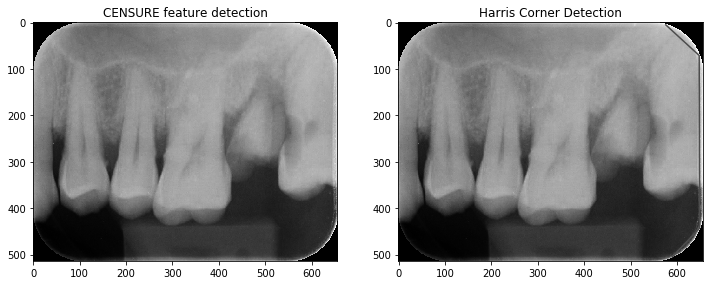

In [66]:
# check a few scikitlearn image feature extractions, if they can help us

from skimage.feature import corner_harris, corner_subpix, corner_peaks, CENSURE

detector = CENSURE()
detector.detect(img)

coords = corner_peaks(corner_harris(img), min_distance=5)
coords_subpix = corner_subpix(img, coords, window_size=13)

plt.subplot(121)
plt.title('CENSURE feature detection')
plt.imshow(img, cmap='gray')
plt.scatter(detector.keypoints[:, 0], detector.keypoints[:, 1],
              2 ** detector.scales, facecolors='none', edgecolors='r')

plt.subplot(122)
plt.title('Harris Corner Detection')
plt.imshow(img, cmap='gray')  # show me the leaf
plt.plot(coords[:, 1], coords[:, 0], '.3', markersize=5)
plt.show()

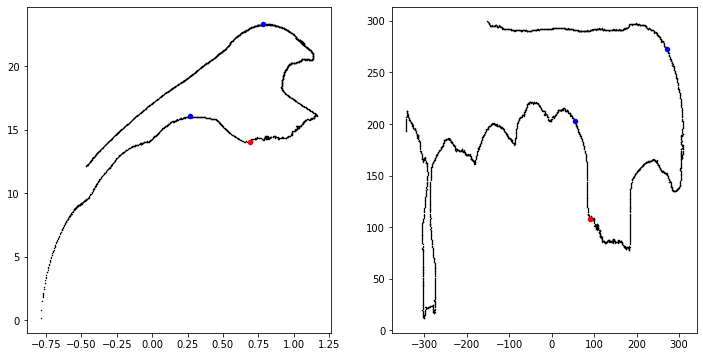

In [69]:
from scipy.signal import argrelextrema

# for local maxima
c_max_index = argrelextrema(polar_contour[::,0], np.greater, order=50)
c_min_index = argrelextrema(polar_contour[::,0], np.less, order=50)

plt.subplot(121)
plt.scatter(polar_contour[::,1], polar_contour[::,0], 
            linewidth=0, s=2, c='k')
plt.scatter(polar_contour[::,1][c_max_index], 
            polar_contour[::,0][c_max_index], 
            linewidth=0, s=30, c='b')
plt.scatter(polar_contour[::,1][c_min_index], 
            polar_contour[::,0][c_min_index], 
            linewidth=0, s=30, c='r')

plt.subplot(122)
plt.scatter(contour[::,1], contour[::,0], 
            linewidth=0, s=2, c='k')
plt.scatter(contour[::,1][c_max_index], 
            contour[::,0][c_max_index], 
            linewidth=0, s=30, c='b')
plt.scatter(contour[::,1][c_min_index], 
            contour[::,0][c_min_index], 
            linewidth=0, s=30, c='r')

plt.show()


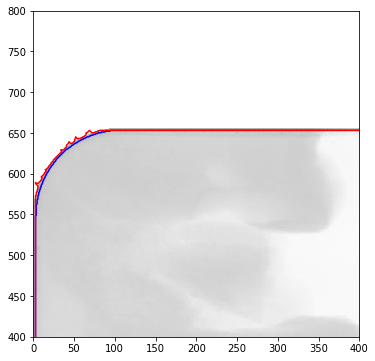

In [71]:
def cont(img):
    return max(measure.find_contours(img, .8), key=len)

# let us set the 'brush' to a 6x6 circle
struct = [[ 0., 0., 1., 1., 0., 0.],
          [ 0., 1., 1., 1., 1., 0.],  
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 0., 1., 1., 1., 1., 0.],
          [ 0., 0., 1., 1., 0., 0.]]

erosion = cont(ndi.morphology.binary_erosion(img, structure=struct).astype(img.dtype))
closing = cont(ndi.morphology.binary_closing(img, structure=struct).astype(img.dtype))
opening = cont(ndi.morphology.binary_opening(img, structure=struct).astype(img.dtype))
dilation = cont(ndi.morphology.binary_dilation(img, structure=struct).astype(img.dtype))

plt.imshow(img.T, cmap='Greys', alpha=.3)
plt.plot(erosion[::,0], erosion[::,1], c='b')
plt.plot(opening[::,0], opening[::,1], c='g')
plt.plot(closing[::,0], closing[::,1], c='r')
plt.plot(dilation[::,0], dilation[::,1], c='k')
#plt.xlim([220, 420])
#plt.ylim([250, 420])
plt.xlim([0, 400])
plt.ylim([400, 800])
plt.show()

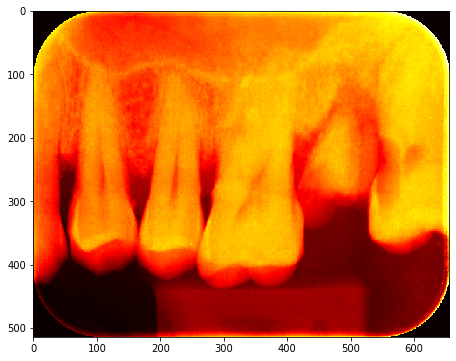

In [88]:
plt.imshow(img.astype(float), cmap='hot')
plt.show()

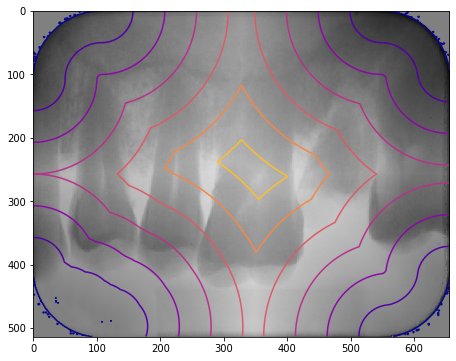

In [89]:

dist_2d = ndi.distance_transform_edt(img)
plt.imshow(img, cmap='Greys', alpha=1)
plt.imshow(dist_2d, cmap='gray', alpha=0.5)
plt.contour(dist_2d, cmap='plasma')
plt.show()

In [94]:
from skimage.feature import canny
from skimage import util

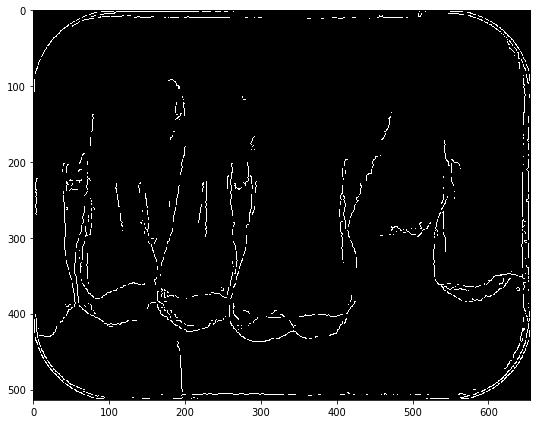

In [111]:
hist, hist_centers = histogram(img)
edges = canny(img/0.8)
io.imshow(edges)

In [120]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image, ImageEnhance
import skimage
from skimage import io
from skimage import color
from skimage.filters import threshold_otsu, unsharp_mask, sobel, laplace
from skimage.feature import canny
from skimage.transform import rescale
from scipy import ndimage as ndi

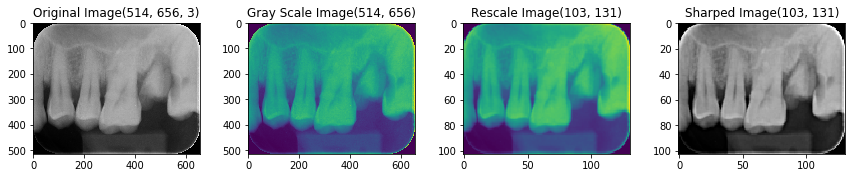

In [121]:

data_dir = 'catagorical_data/3-missing_tooth/'
sample_img = Image.open(os.path.join(data_dir, '100.jpg')) #Read the original Image
sample_img_array = np.asarray(sample_img)

grayscale_img = color.rgb2gray(sample_img_array) #converting Sample Image to Gray Scale
rescale_img = rescale(grayscale_img, scale=0.2) #20% Rescaleing of Img
sharped_img = unsharp_mask(rescale_img, radius=2, amount=1) #Sharpen the Img

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 12)) #Create Subplots

#ploting Sample Img
ax1.imshow(sample_img)
ax1.title.set_text(f'Original Image{np.shape(sample_img)}')

#ploting Gray Scale Img
ax2.imshow(grayscale_img)
ax2.title.set_text(f'Gray Scale Image{np.shape(grayscale_img)}')

#ploting Rescaled Img
ax3.imshow(rescale_img)
ax3.title.set_text(f'Rescale Image{np.shape(rescale_img)}')

#ploting Sharpe Img
ax4.imshow(sharped_img, cmap='gray')
ax4.title.set_text(f'Sharped Image{np.shape(sharped_img)}')


fig.tight_layout()

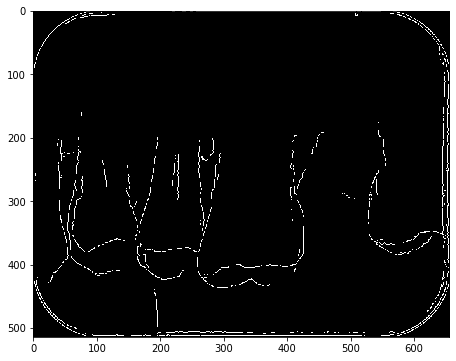

In [129]:
grayscale_edges = plt.imshow(canny(grayscale_img/1), cmap='gray')

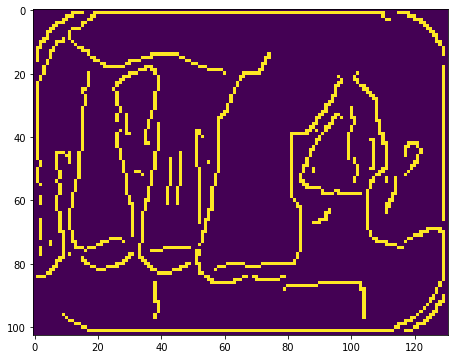

In [130]:
rescale_edges = plt.imshow(canny(rescale_img))

In [132]:
img = color.rgb2gray(img)
img_rescale = rescale(img, 0.5)
print(np.shape(img))
print(np.shape(img_rescale))

(514, 656)
(257, 328)


(array([12740.,  6682.,  4925.,   989.,   589.,   336.,   490.,   529.,
          616.,  1659.,  2344.,  4582.,  5972.,  7038.,  5899.,  3069.,
         3537.,  3099.,  4606.,  8786.,  4730.,  3083.,  1611.,  1422.,
         1287.,   888.,  1274.,  1312.,  1350.,  1552.,  1101.,  1684.,
         1945.,  1978.,  2218.,  1830.,  3175.,  3903.,  4489.,  5219.,
         3656.,  5843.,  6238.,  6465.,  6354.,  4470.,  7143.,  7788.,
         9035.,  9988.,  7215., 11591., 12251., 11750., 11070.,  7049.,
        11022., 12238., 13765., 13739.,  7364.,  7804.,  5251.,  4160.,
         2294.,   799.,   737.,   625.,   543.,   432.,   235.,   326.,
          258.,   262.,   256.,   137.,   185.,   163.,   205.,   216.,
          131.,   194.,   176.,   161.,   115.,    88.,   140.,   297.,
          165.,   115.,   142.]),
 array([0.        , 0.01098901, 0.02197802, 0.03296703, 0.04395604,
        0.05494505, 0.06593407, 0.07692308, 0.08791209, 0.0989011 ,
        0.10989011, 0.12087912, 0.1318

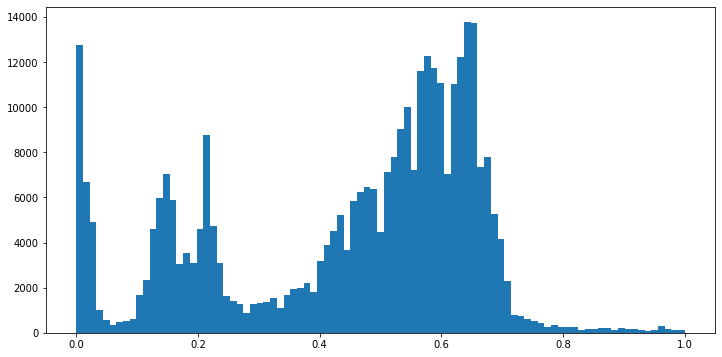

In [136]:
plt.hist(img.flat,
         bins='auto', 
         range=(0,1))

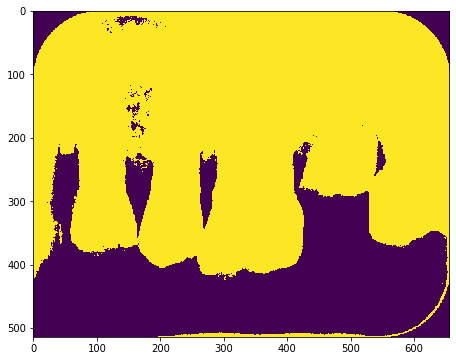

In [149]:
background = (img <= 1)
img_data = (img>0.4)
plt.imshow(img_data)